<a href="https://colab.research.google.com/github/ansariwaleed/MNE_documentation_implementation/blob/main/Annotating_continous_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Data

In [9]:
import os
from datetime import timedelta

import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw.crop(tmax=60).load_data()

Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

Creating annotations programmatically

In [11]:
my_annot = mne.Annotations(
     onset=[3, 5, 7],  # in seconds
    duration=[1, 0.5, 0.25],  # in seconds, too
    description=["AAA", "BBB", "CCC"],
)
print(my_annot)

<Annotations | 3 segments: AAA (1), BBB (1), CCC (1)>


In [12]:
raw.set_annotations(my_annot)
print(raw.annotations)

# convert meas_date (a tuple of seconds, microseconds) into a float:
meas_date = raw.info["meas_date"]
orig_time = raw.annotations.orig_time
print(meas_date == orig_time)

<Annotations | 3 segments: AAA (1), BBB (1), CCC (1)>
True


In [13]:
time_of_first_sample = raw.first_samp / raw.info["sfreq"]
print(my_annot.onset + time_of_first_sample)
print(raw.annotations.onset)

[45.95597083 47.95597083 49.95597083]
[45.95597083 47.95597083 49.95597083]


f you know that your annotation onsets are relative to some other time, you can set orig_time before you call set_annotations(), and the onset times will get adjusted based on the time difference between your specified orig_time and raw.info['meas_date'], but without the additional adjustment for raw.first_samp. orig_time can be specified in various ways (see the documentation of Annotations for the options); here we’ll use an ISO 8601 formatted string, and set it to be 50 seconds later than raw.info['meas_date'].

In [14]:
time_format = "%Y-%m-%d %H:%M:%S.%f"
new_orig_time = (meas_date + timedelta(seconds=50)).strftime(time_format)
print(new_orig_time)

later_annot = mne.Annotations(
    onset=[3, 5, 7],
    duration=[1, 0.5, 0.25],
    description=["DDD", "EEE", "FFF"],
    orig_time=new_orig_time,
)

raw2 = raw.copy().set_annotations(later_annot)
print(later_annot.onset)
print(raw2.annotations.onset)

2002-12-03 19:02:00.720100
[3. 5. 7.]
[53. 55. 57.]


Using matplotlib as 2D backend.


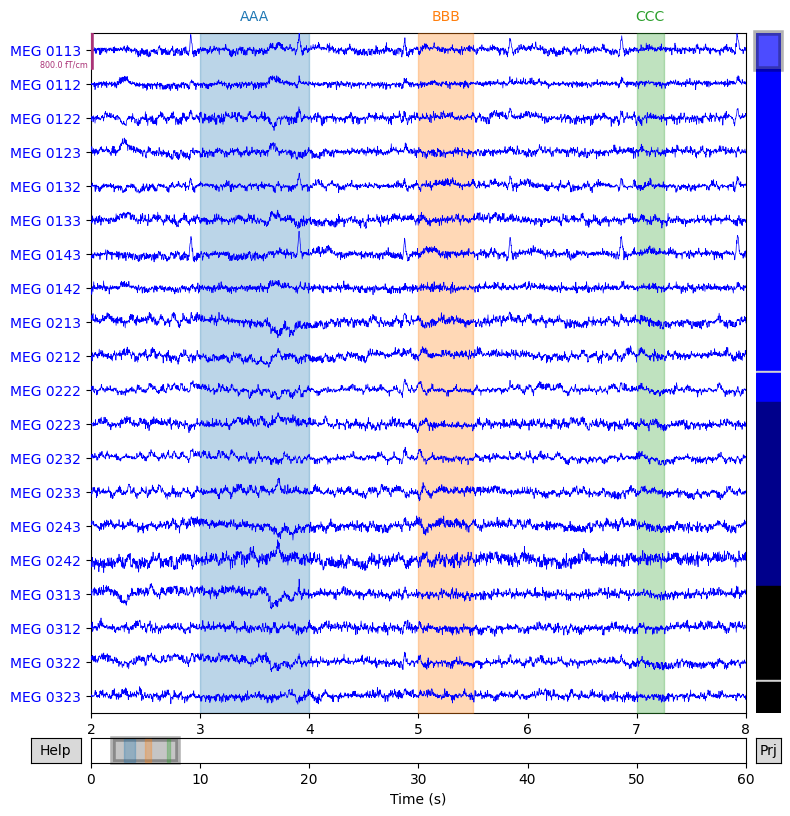

In [15]:
fig = raw.plot(start=2, duration=6)

Annotating Raw objects interactively

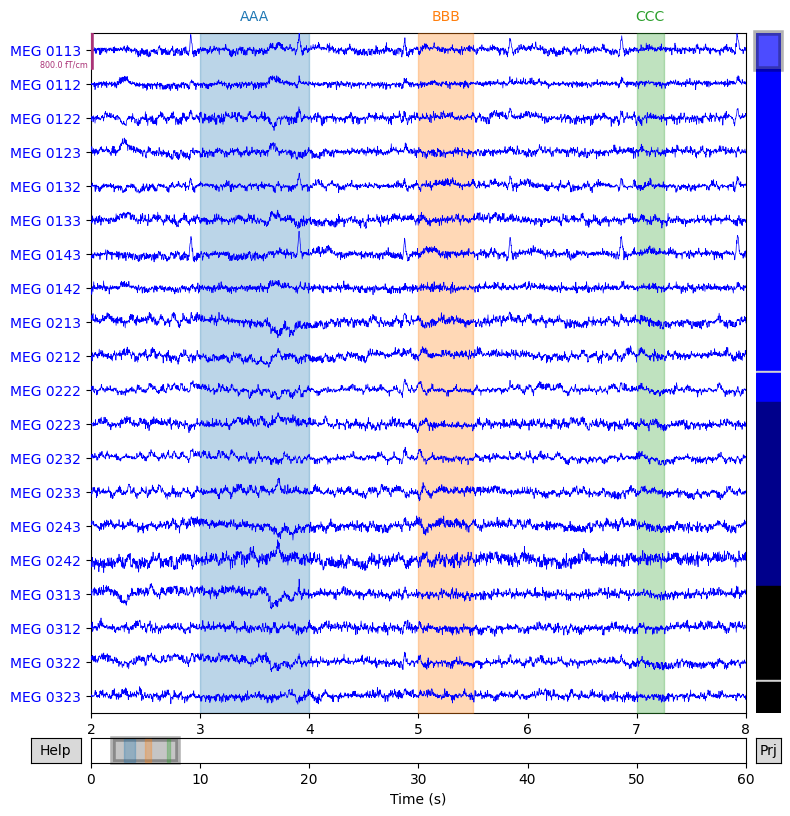

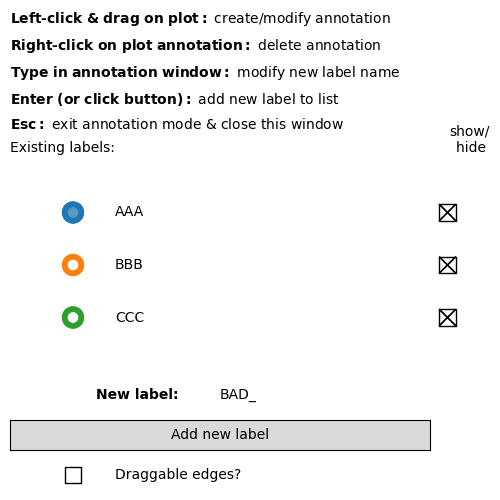

In [16]:
fig = raw.plot(start=2, duration=6)
fig.fake_keypress("a")

How annotations affect preprocessing and analysis
> You may have noticed that the description for new labels in the annotation controls window defaults to BAD_. The reason for this is that annotation is often used to mark bad temporal spans of data (such as movement artifacts or environmental interference that cannot be removed in other ways such as projection or filtering). Several MNE-Python operations are “annotation aware” and will avoid using data that is annotated with a description that begins with “bad” or “BAD”; such operations typically have a boolean reject_by_annotation parameter. Examples of such operations are independent components analysis (mne.preprocessing.ICA), functions for finding heartbeat and blink artifacts (find_ecg_events(), find_eog_events()), and creation of epoched data from continuous data (mne.Epochs). See Rejecting bad data spans and breaks for details.


Operations on Annotations objects

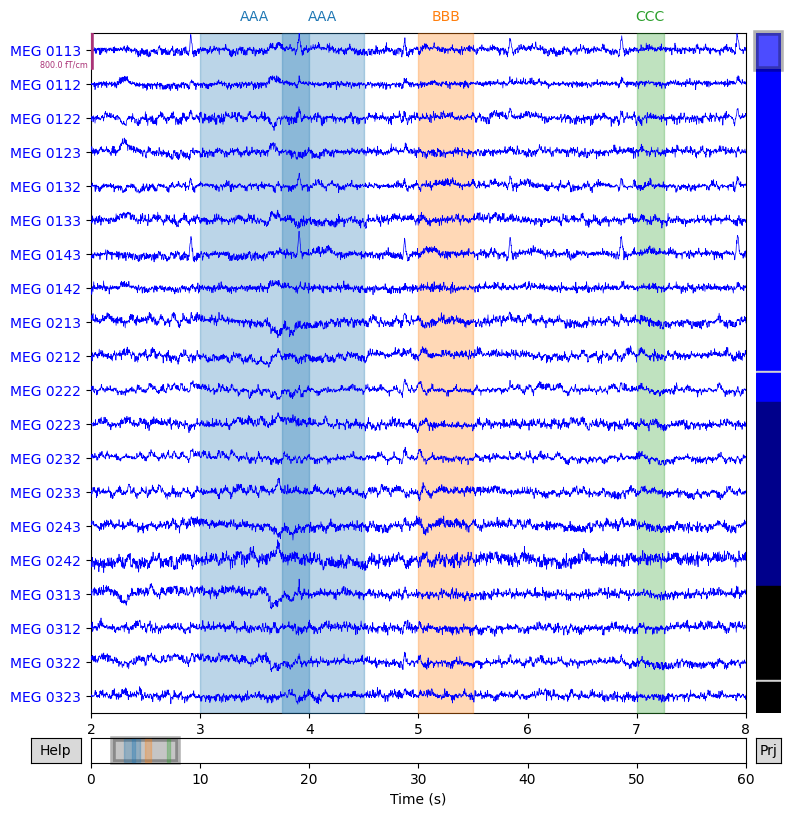

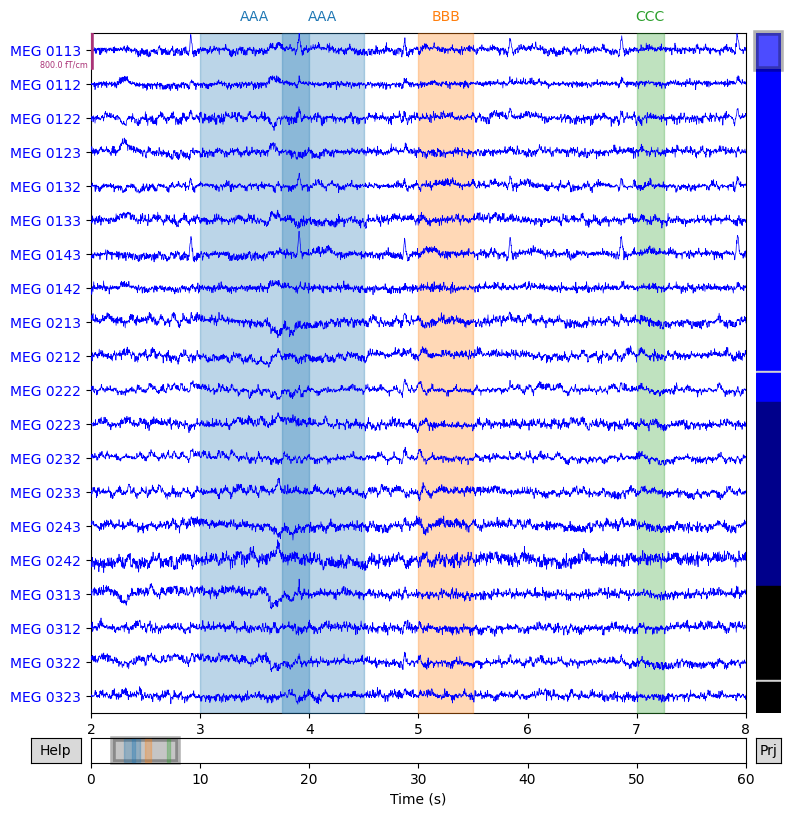

In [19]:
new_annot = mne.Annotations(onset=3.75, duration=0.75, description="AAA")
raw.set_annotations(my_annot + new_annot)
raw.plot(start=2, duration=6)

In [20]:
print(raw.annotations[0])  # just the first annotation
print(raw.annotations[:2])  # the first two annotations
print(raw.annotations[(3, 2)])  # the fourth and third annotations

OrderedDict([('onset', 45.95597082905339), ('duration', 1.0), ('description', 'AAA'), ('orig_time', datetime.datetime(2002, 12, 3, 19, 1, 10, 720100, tzinfo=datetime.timezone.utc))])
<Annotations | 2 segments: AAA (2)>
<Annotations | 2 segments: BBB (1), CCC (1)>


In [21]:
for ann in raw.annotations:
    descr = ann["description"]
    start = ann["onset"]
    end = ann["onset"] + ann["duration"]
    print(f"'{descr}' goes from {start} to {end}")

'AAA' goes from 45.95597082905339 to 46.95597082905339
'AAA' goes from 46.70597082905339 to 47.45597082905339
'BBB' goes from 47.95597082905339 to 48.45597082905339
'CCC' goes from 49.95597082905339 to 50.20597082905339


In [23]:
# later_annot WILL be changed, because we're modifying the first element of
# later_annot.onset directly:
later_annot.onset[0] = 99

# later_annot WILL NOT be changed, because later_annot[0] returns a copy
# before the 'onset' field is changed:
later_annot[0]["onset"] = 77

print(later_annot[0]["onset"])

99.0


Reading and writing Annotations to/from a file

In [24]:
raw.annotations.save("saved-annotations.csv", overwrite=True)
annot_from_file = mne.read_annotations("saved-annotations.csv")
print(annot_from_file)

<Annotations | 4 segments: AAA (2), BBB (1), CCC (1)>
